# TSA Complaints

## Introduction

This project focuses on analyzing TSA (Transportation Security Administration) complaints data to identify trends, patterns, and key insights. The data includes complaints categorized by airport, category, sub-category, and other relevant attributes. By leveraging this data, we aim to provide a comprehensive overview of the complaint landscape across various airports and categories.

## Purpose

The primary purpose of this project is to:

- Understand the distribution and frequency of TSA complaints across different airports.
- Identify the most common categories and sub-categories of complaints.
- Analyze trends over time to detect any significant changes or patterns.
- Provide actionable insights to help improve TSA services and passenger experiences.

## Key Deliverables

1. **Data Loading and Preprocessing**: Scripts to load and preprocess complaint data from multiple CSV files.
2. **Data Cleansing**: Procedures to cleanse and standardize the data, including handling missing values and renaming columns for clarity.
3. **Exploratory Data Analysis (EDA)**: Visualizations and summaries to explore the data, including bar plots, box plots, and heatmaps.
4. **Trend Analysis**: Analysis of complaint trends over time, focusing on recent years (2022-2023).
5. **Category and Sub-category Analysis**: Detailed examination of the top complaint categories and sub-categories.
6. **Geospatial Analysis**: Mapping complaints data to visualize the distribution across different airports and states.
7. **Reporting and Insights**: Comprehensive report summarizing the findings and providing recommendations for TSA improvements.


In [16]:
# Import necessary libraries
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For plotting and visualization
import seaborn as sns  # For statistical data visualization
import os  # For interacting with the operating system
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting
from sklearn.preprocessing import StandardScaler  # For data preprocessing (scaling)


In [17]:
# This script loads complaint data from multiple CSV files, extracts the first 20 records from each dataset, and exports them to new files for 
# sampling and quick analysis. It also provides easy access to individual dataframes by category, sub-category, airport, and IATA/ICAO codes.

# Install pandas if not already installed
%pip install pandas

import os
import pandas as pd

# Set dataset directory to a subdirectory named 'data'
dataset_directory = os.path.join(os.getcwd(), 'data')

# Define file names
file_names = ['complaints-by-airport.csv', 'complaints-by-category.csv', 'complaints-by-subcategory.csv', 'iata-icao.csv']

# Initialize a dictionary to hold DataFrames
dataframes = {}

# Define the data types for each CSV file
dtypes = {
    'complaints-by-airport.csv': {'pdf_report_date': 'object', 'airport': 'object', 'year_month': 'object', 'count': 'int64'},
    'complaints-by-category.csv': {'pdf_report_date': 'object', 'airport': 'object', 'category': 'object', 'year_month': 'object', 'count': 'int64', 'clean_cat': 'object', 'clean_cat_status': 'object'},
    'complaints-by-subcategory.csv': {'pdf_report_date': 'object', 'airport': 'object', 'category': 'object', 'subcategory': 'object', 'year_month': 'object', 'count': 'float64', 'clean_cat': 'object', 'clean_subcat': 'object', 'clean_cat_status': 'object', 'clean_subcat_status': 'object', 'is_category_prefix_removed': 'object'},
    'iata-icao.csv': {'country_code': 'object', 'region_name': 'object', 'iata': 'object', 'icao': 'object', 'airport': 'object', 'latitude': 'float64', 'longitude': 'float64'}
}

# Iterate through each file
for file_name in file_names:
    # Create full path for each file
    csv_file_path = os.path.join(dataset_directory, file_name)
    
    # Check if the file exists
    if not os.path.exists(csv_file_path):
        print(f"File '{csv_file_path}' does not exist.")
    else:
        # Read the CSV file into a DataFrame with specified dtype for mixed type columns
        df = pd.read_csv(csv_file_path, dtype=dtypes[file_name], low_memory=False)
        
        # Store the DataFrame in the dictionary with the file name (without .csv) as the key
        dataframes[file_name.replace('.csv', '')] = df
        
        # Select only the first 20 records
        df_first_20 = df.head(20)
        
        # Export the DataFrame to a new file with "_exported" appended
        export_path = os.path.join(dataset_directory, file_name.replace('.csv', '_exported.csv'))
        df_first_20.to_csv(export_path, index=False)

# Access individual DataFrames
airport_df = dataframes.get('complaints-by-airport')
category_df = dataframes.get('complaints-by-category')
subcategory_df = dataframes.get('complaints-by-subcategory')
iata_df = dataframes.get('iata-icao')



Note: you may need to restart the kernel to use updated packages.


In [18]:
# This script processes the category data by standardizing the date format, renaming columns for clarity, and extracting the year 
# from the year_month column. It then re-aggregates complaint totals by airport, year, and category to produce a cleaned and summarized
# dataset suitable for yearly trend analysis. Category data: Cleanse the category data and grouped

category_df['year_month'] = pd.to_datetime(category_df['year_month']).dt.strftime('%Y/%m')
category_data = category_df[['airport', 'year_month', 'count', 'clean_cat']].rename(columns={
    'count': 'total', 'clean_cat': 'category'
})

# Parsing 'year_month' with the specified format to extract 'year' consistently
category_data['year'] = pd.to_datetime(category_data['year_month'], format='%Y/%m').dt.year

# Re-aggregate by airport, year, and category to confirm the update
yearly_category_data = category_data.groupby(['airport', 'year', 'category'], as_index=False).agg({'total': 'sum'})



In [19]:
# Filtering and Aggregating Category Data for Top Airports and Categories

# This code filters the yearly category data to retain only the top 20 airports by total complaint counts 
# and the top 10 categories within these airports. The filtered data provides a focused view of the 
# highest-impact areas in terms of airport complaints, enabling targeted analysis and reporting.


# Filter for the top 20 airports and top 10 categories
top_airports = yearly_category_data.groupby('airport')['total'].sum().nlargest(20).index
top_airports_data = yearly_category_data[yearly_category_data['airport'].isin(top_airports)]

top_categories = top_airports_data.groupby('category')['total'].sum().nlargest(10).index
top_categories_data = top_airports_data[top_airports_data['category'].isin(top_categories)]



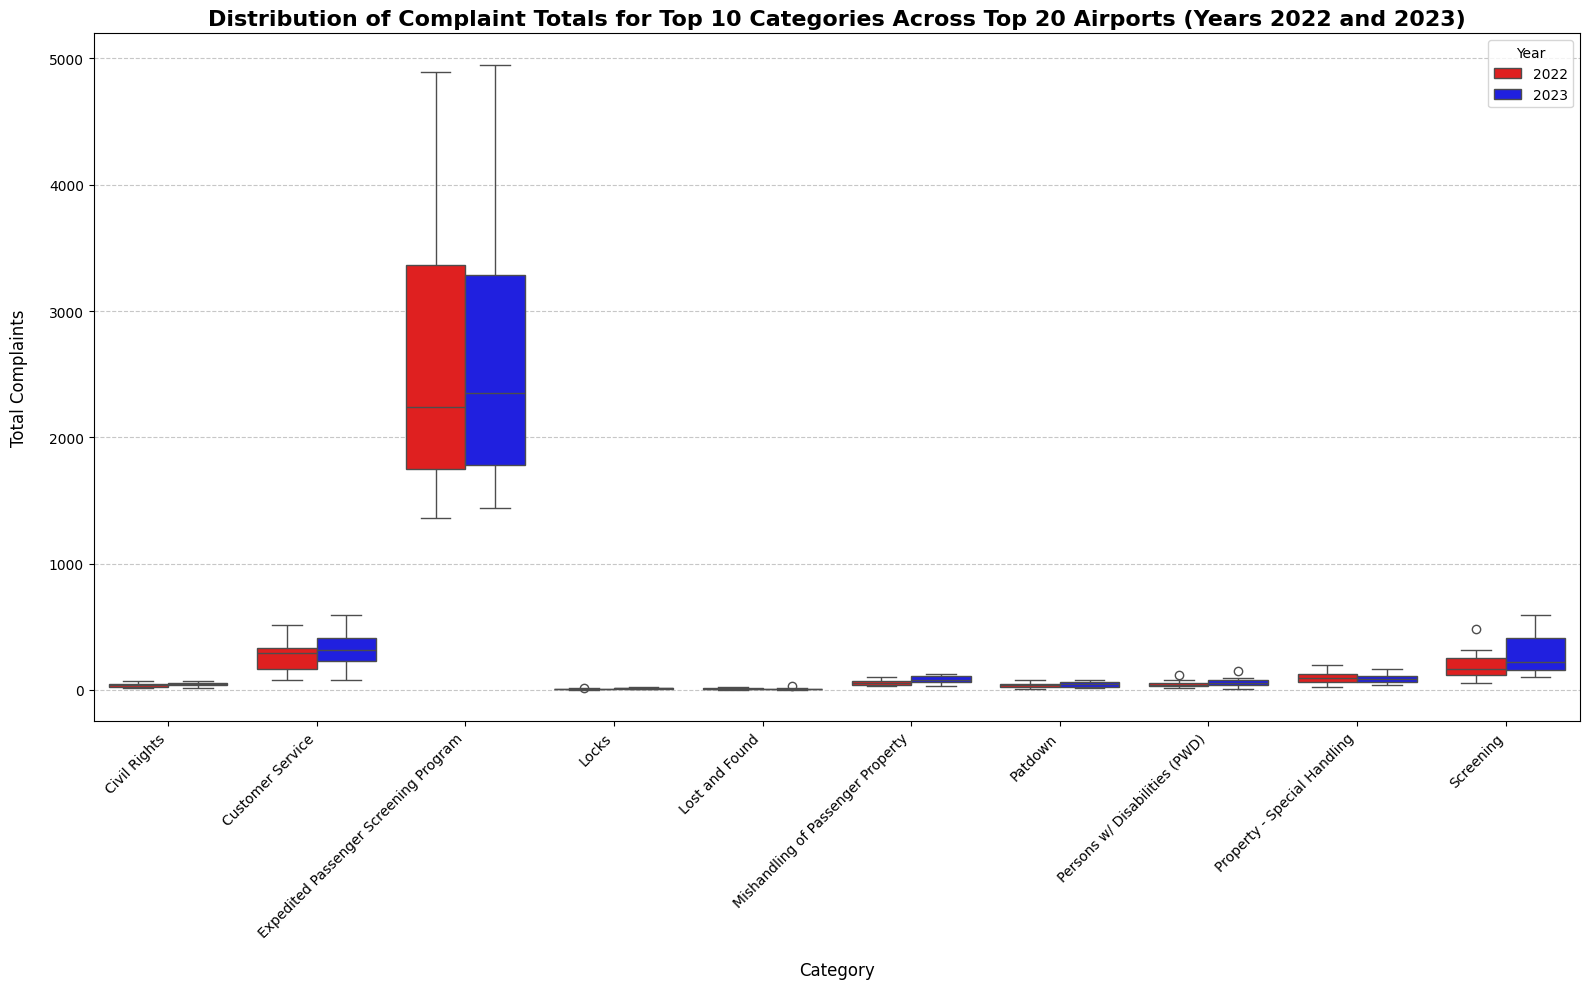

In [20]:
# Filtering Data for Recent Years and Visualizing Complaint Distributions

# This code filters the dataset to include only complaints from the years 2022 and 2023 within the top 10 categories
# across the top 20 airports. It then generates a box plot to visualize the distribution of complaint totals 
# for these categories over the two years, allowing for a comparative analysis of complaint patterns in 2022 vs. 2023.
# Custom colors are used to distinguish each year, enhancing readability and interpretability.

# Filtering data for the years 2022 and 2023
data_2022_2023 = top_categories_data[top_categories_data['year'].isin([2022, 2023])]

# Creating a box plot for the top 10 categories across the top 20 airports for the years 2022 and 2023
plt.figure(figsize=(16, 10))
sns.boxplot(data=data_2022_2023, x='category', y='total', hue='year', 
            palette={2022: "red", 2023: "blue"})  # Custom colors for each year

# Customizing the plot for clarity and readability
plt.title('Distribution of Complaint Totals for Top 10 Categories Across Top 20 Airports (Years 2022 and 2023)', fontsize=16, fontweight='bold')
plt.xlabel('Category', fontsize=12, labelpad=15)
plt.ylabel('Total Complaints', fontsize=12, labelpad=15)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Year', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()



In [21]:
# Header:
# Stacked Bar Plot for Complaint Totals by Category and Year (2022 & 2023)

# This code generates a stacked bar chart comparing the total complaints for each category across the top 20 airports 
# for the years 2022 and 2023. The stacked bars highlight the contribution of each year to the overall complaint totals 
# within each category, providing a clear visual representation of year-over-year changes in complaint volumes.

import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Summing complaint totals by year and category
stacked_data_2022_2023 = data_2022_2023.groupby(['category', 'year'])['total'].sum().unstack(fill_value=0)

# Preparing the data for Plotly
categories = stacked_data_2022_2023.index
complaints_2022 = stacked_data_2022_2023[2022]
complaints_2023 = stacked_data_2022_2023[2023]

# Creating the figure with Plotly
fig = go.Figure()

# Adding 2022 data
fig.add_trace(go.Bar(
    x=categories,
    y=complaints_2022,
    name='2022',
    marker_color='coral'
))

# Adding 2023 data
fig.add_trace(go.Bar(
    x=categories,
    y=complaints_2023,
    name='2023',
    marker_color='dodgerblue'
))

# Customizing layout for clarity
fig.update_layout(
    title='Total Complaints by Category for Top 20 Airports (2022 vs 2023)',
    xaxis_title='Complaint Category',
    yaxis_title='Total Complaints',
    barmode='stack',  # Stack bars for each category
    legend_title='Year',
    xaxis_tickangle=-45,
    template='plotly_white',  # Clean layout
    width=900,  # Set width for better spacing
    height=600  # Set height for clarity
)

# Display the figure
fig.show()





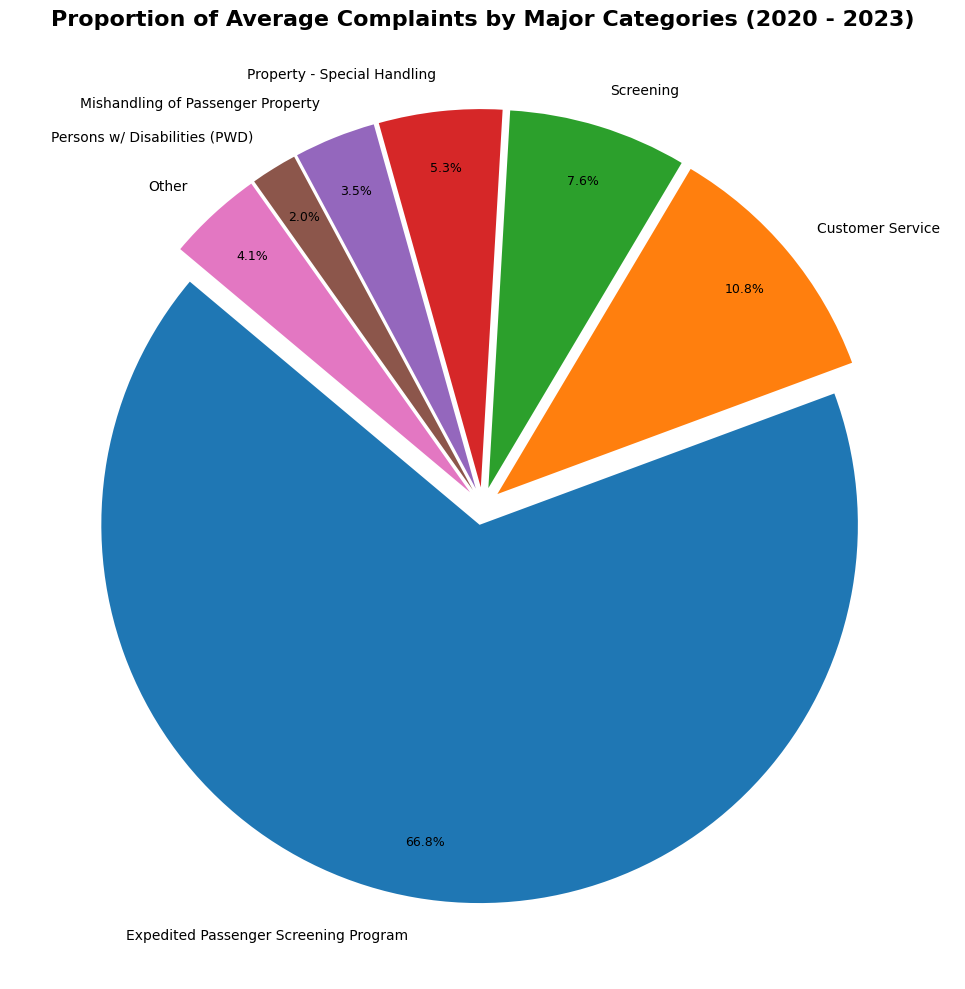

In [22]:
# Step 1: Filter data for the last 4 years (2020–2023)
data_last_4_years = top_categories_data[top_categories_data['year'].isin([2020, 2021, 2022, 2023])]

# Step 2: Calculate average complaints per category for the filtered years
category_totals_last_4_years_avg = data_last_4_years.groupby('category')['total'].mean()

# Step 3: Limit to top categories and group the rest as 'Other'
# Sort categories by average complaints, take top 6, and sum the rest into 'Other'
top_categories = category_totals_last_4_years_avg.nlargest(6)
other_categories_sum = category_totals_last_4_years_avg.drop(top_categories.index).sum()
category_totals_final = pd.concat([top_categories, pd.Series(other_categories_sum, index=['Other'])])

# Step 4: Create a pie chart with the refined data and improved label positioning
plt.figure(figsize=(10, 10))
wedges, texts, autotexts = plt.pie(
    category_totals_final, 
    labels=category_totals_final.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    pctdistance=0.85,  # Adjust label placement
    explode=[0.05] * len(category_totals_final)  # Slightly explode each slice for spacing
)

# Adjust label text for better readability
for text in texts:
    text.set_fontsize(10)
for autotext in autotexts:
    autotext.set_fontsize(9)

# Set the title
plt.title('Proportion of Average Complaints by Major Categories (2020 - 2023)', fontsize=16, fontweight='bold')

# Display the pie chart
plt.tight_layout()
plt.show()




** Cleansing sub Category Data Set **


In [23]:
# Processing subcategory data 


# Selecting specified columns and renaming them
cleansed_subcategory_df = subcategory_df[['airport', 'clean_cat', 'clean_subcat', 'count', 'year_month']].rename(columns={
    'clean_cat': 'category', 
    'clean_subcat': 'sub_category'
})

# Replace sub_category with category where sub_category is only '*'
cleansed_subcategory_df['sub_category'] = cleansed_subcategory_df.apply(
    lambda row: row['category'] if row['sub_category'] == '*' else row['sub_category'], axis=1
)

# Filtering for the last 4 years (2020–2023) and formatting year_month to YYYY/MM
cleansed_subcategory_df['year_month'] = pd.to_datetime(cleansed_subcategory_df['year_month'], errors='coerce').dt.strftime('%Y/%m')
cleansed_subcategory_df.dropna(inplace=True)  # Remove rows with any blank records

# Further filter for the last 4 years
cleansed_subcategory_df['year'] = pd.to_datetime(cleansed_subcategory_df['year_month'], format='%Y/%m').dt.year
cleansed_subcategory_df = cleansed_subcategory_df[cleansed_subcategory_df['year'].isin([2023])]

# Aggregating complaint counts by airport and summing them up
airport_subcat_complaints_sum = cleansed_subcategory_df.groupby('airport')['count'].sum()

# Extracting the top 20 airports by total complaints
top_20_airports_subcat = airport_subcat_complaints_sum.nlargest(20).index

# Filtering the cleansed subcategory dataframe for the top 20 airports
subcategory_top_20_df = cleansed_subcategory_df[cleansed_subcategory_df['airport'].isin(top_20_airports_subcat)]


# Aggregating complaint count for these top 20 airports
subcategory_top_20_df = subcategory_top_20_df.groupby(['airport', 'category', 'sub_category']).agg({'count': 'sum'}).reset_index()

# Displaying the final aggregated data for the top 20 airports
subcategory_top_20_df


,airport,category,sub_category,count
0,ATL,Additional Information Required/Insufficient I...,EMAIL ONLY,4.0
1,ATL,Airline,Lost Baggage,3.0
2,ATL,Airline,Policy/Regulations/Service,11.0
3,ATL,Airline,Wheelchair Assistance,1.0
4,ATL,Cargo,Known Shipper,1.0
...,...,...,...,...
1317,SFO,Screening,Inconsistency,16.0
1318,SFO,Screening,Lengthy Lines,10.0
1319,SFO,Screening,Procedures/Process,99.0
1320,SFO,Screening,Retrieving Abandoned/Confiscated Items,7.0


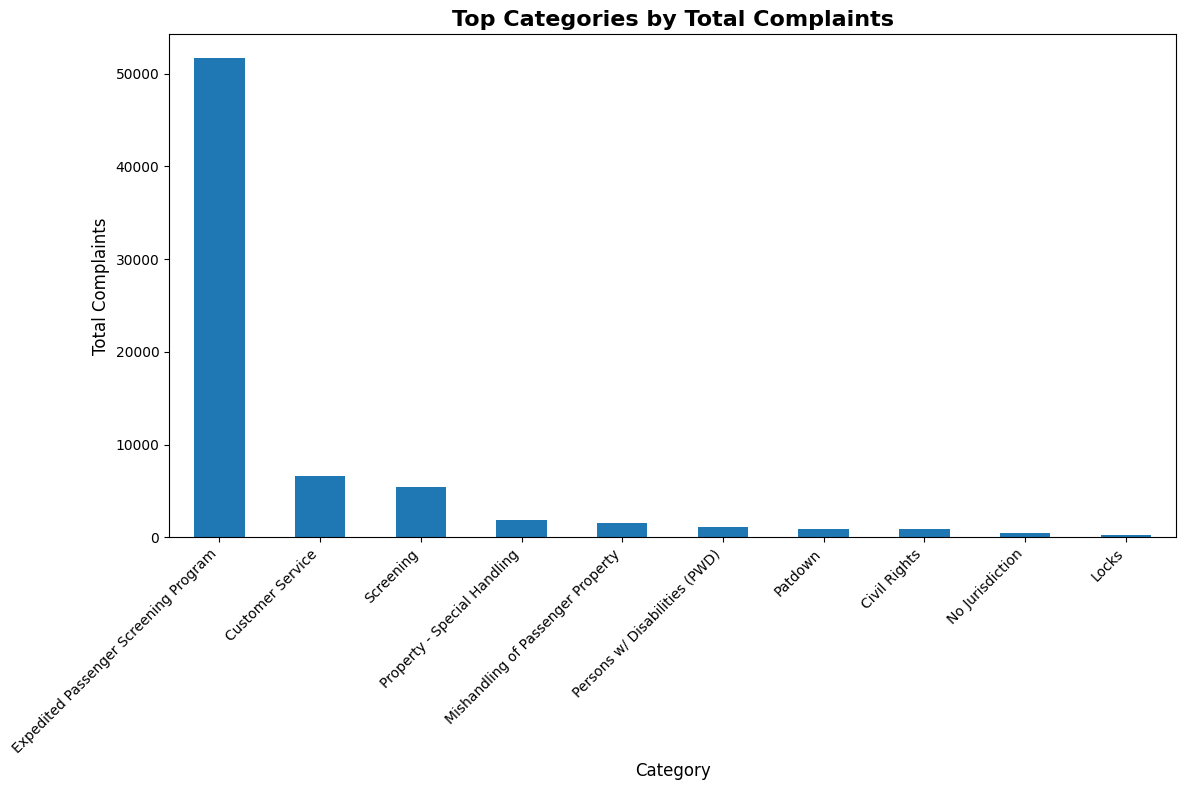

In [24]:
import matplotlib.pyplot as plt

# Step 1: Aggregate data to get total complaints per main category
category_totals = subcategory_top_20_df.groupby('category')['count'].sum().nlargest(10)

# Plotting the Top Categories by Total Complaints
plt.figure(figsize=(12, 8))
category_totals.plot(kind='bar')

# Customizing the plot for clarity
plt.title('Top Categories by Total Complaints', fontsize=16, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Total Complaints', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Display the bar chart
plt.tight_layout()
plt.show()


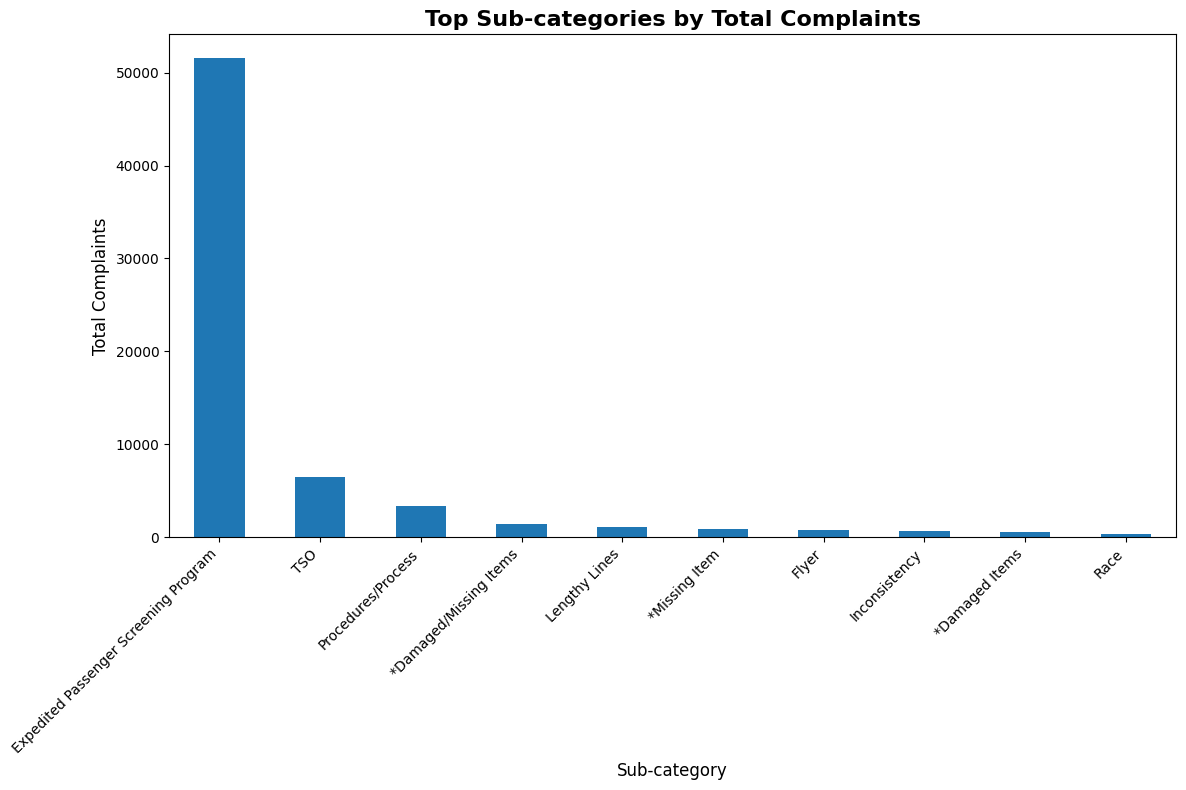

In [25]:
# Plotting the top sub-categories by total complaints

import matplotlib.pyplot as plt


# Calculating total complaints by sub-category across all categories and sorting them
top_subcategories = subcategory_top_20_df.groupby('sub_category')['count'].sum().nlargest(10)


# Creating a bar plot for the top sub-categories based on the sample data
plt.figure(figsize=(12, 8))
top_subcategories.plot(kind='bar')

# Customizing the plot
plt.title('Top Sub-categories by Total Complaints', fontsize=16, fontweight='bold')
plt.xlabel('Sub-category', fontsize=12)
plt.ylabel('Total Complaints', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Display the bar plot
plt.tight_layout()
plt.show()


<Figure size 1400x800 with 0 Axes>

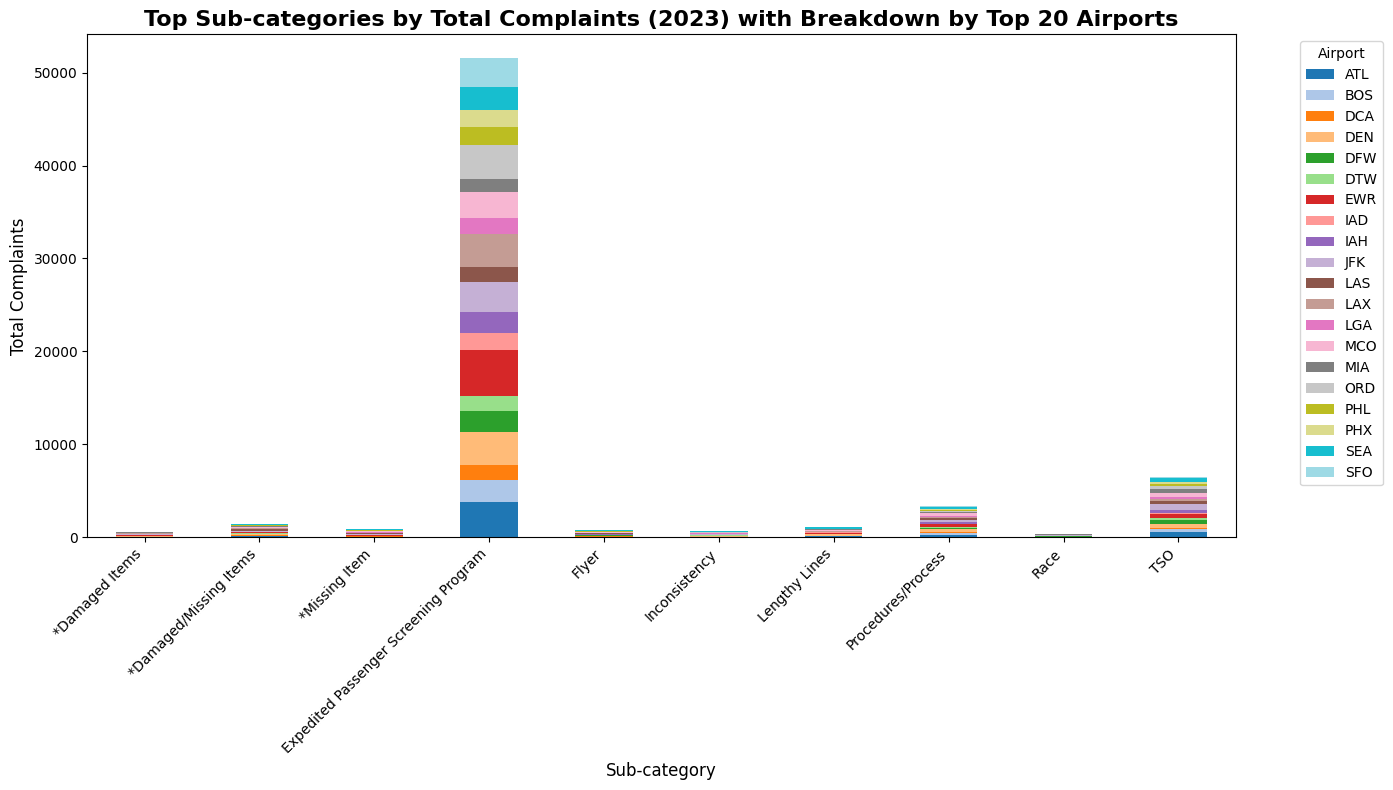

In [26]:
# Updating the code to limit data to the last 3 years and create a stacked bar chart by airport within top sub-categories
import matplotlib.pyplot as plt
import pandas as pd



# Step 1: Calculate total complaints by sub-category and select the top 10 sub-categories
top_subcategories = subcategory_top_20_df.groupby('sub_category')['count'].sum().nlargest(10).index
filtered_data = subcategory_top_20_df[subcategory_top_20_df['sub_category'].isin(top_subcategories)]

# Step 2: Pivot the data to get a breakdown by sub-category and airport
pivot_data = filtered_data.pivot_table(index='sub_category', columns='airport', values='count', aggfunc='sum', fill_value=0)

# Step 3: Plot the stacked bar chart
plt.figure(figsize=(14, 8))
pivot_data.plot(kind='bar', stacked=True, colormap='tab20', figsize=(14, 8))

# Customizing the plot
plt.title('Top Sub-categories by Total Complaints (2023) with Breakdown by Top 20 Airports', fontsize=16, fontweight='bold')
plt.xlabel('Sub-category', fontsize=12)
plt.ylabel('Total Complaints', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Airport', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot

# Display the stacked bar plot
plt.tight_layout()
plt.show()


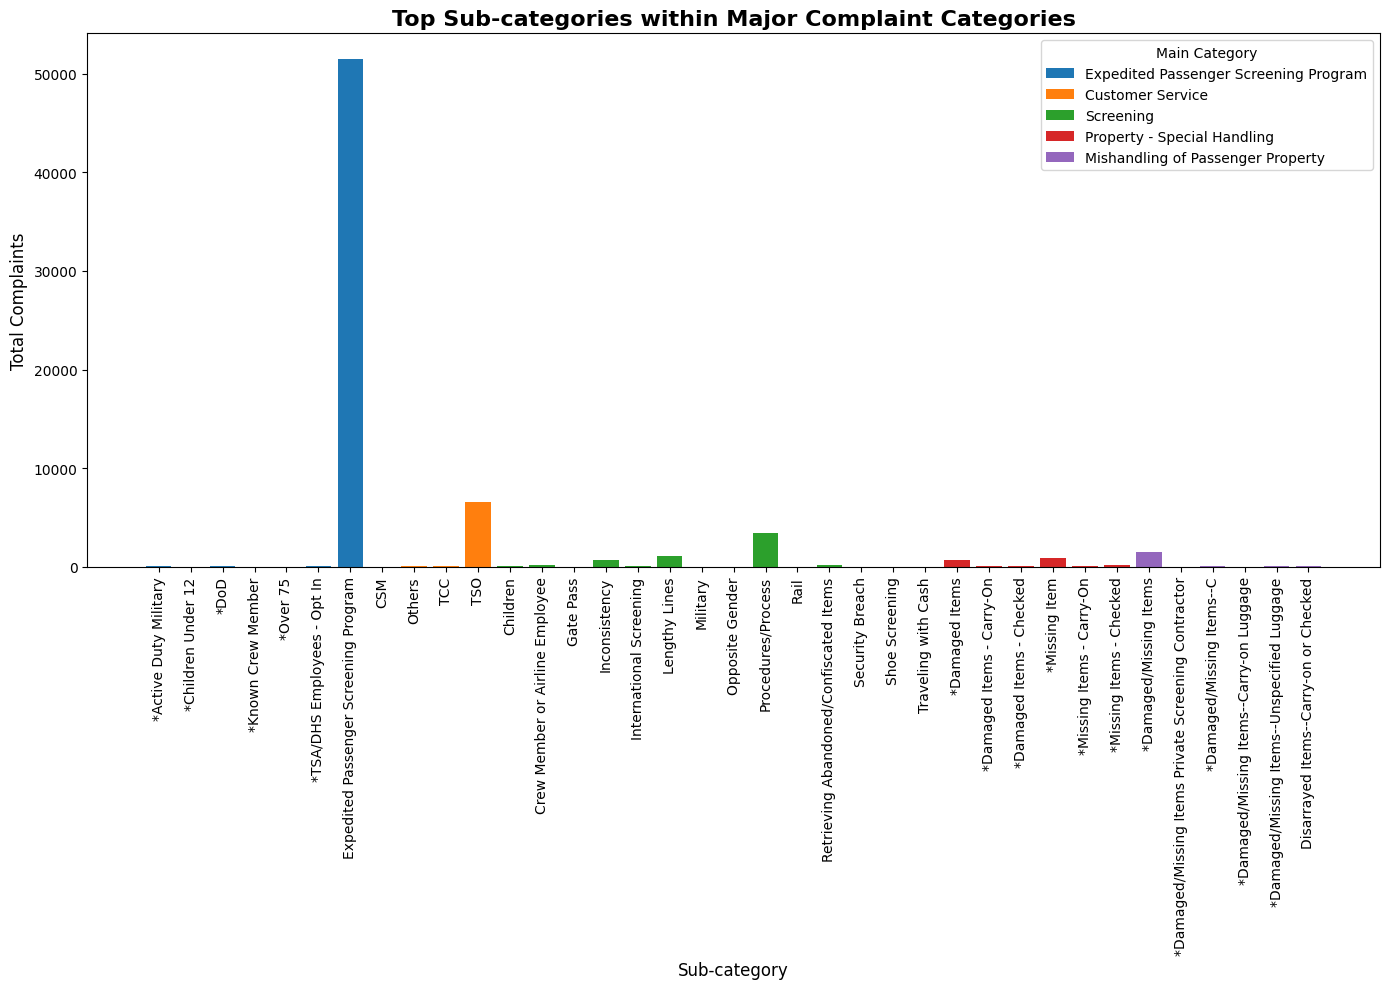

In [27]:

# Selecting the top 5 main categories based on the total complaint counts
top_categories = subcategory_top_20_df.groupby('category')['count'].sum().nlargest(5).index
top_subcategory_data = subcategory_top_20_df[subcategory_top_20_df['category'].isin(top_categories)]

# Further aggregate to get complaint counts for each sub-category within the top categories
top_subcategory_totals = top_subcategory_data.groupby(['category', 'sub_category'])['count'].sum().reset_index()

# Plotting the top sub-categories within each of the top main categories using a stacked bar chart
plt.figure(figsize=(14, 10))
for category in top_categories:
    subset = top_subcategory_totals[top_subcategory_totals['category'] == category]
    plt.bar(subset['sub_category'], subset['count'], label=category)

# Customizing the plot
plt.title('Top Sub-categories within Major Complaint Categories', fontsize=16, fontweight='bold')
plt.xlabel('Sub-category', fontsize=12)
plt.ylabel('Total Complaints', fontsize=12)
plt.xticks(rotation=90)
plt.legend(title='Main Category')

# Display the plot
plt.tight_layout()
plt.show()


/var/folders/h_/c1p094dx3qv9xk8qkfwl_lxm0000gn/T/ipykernel_95937/1493060269.py:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



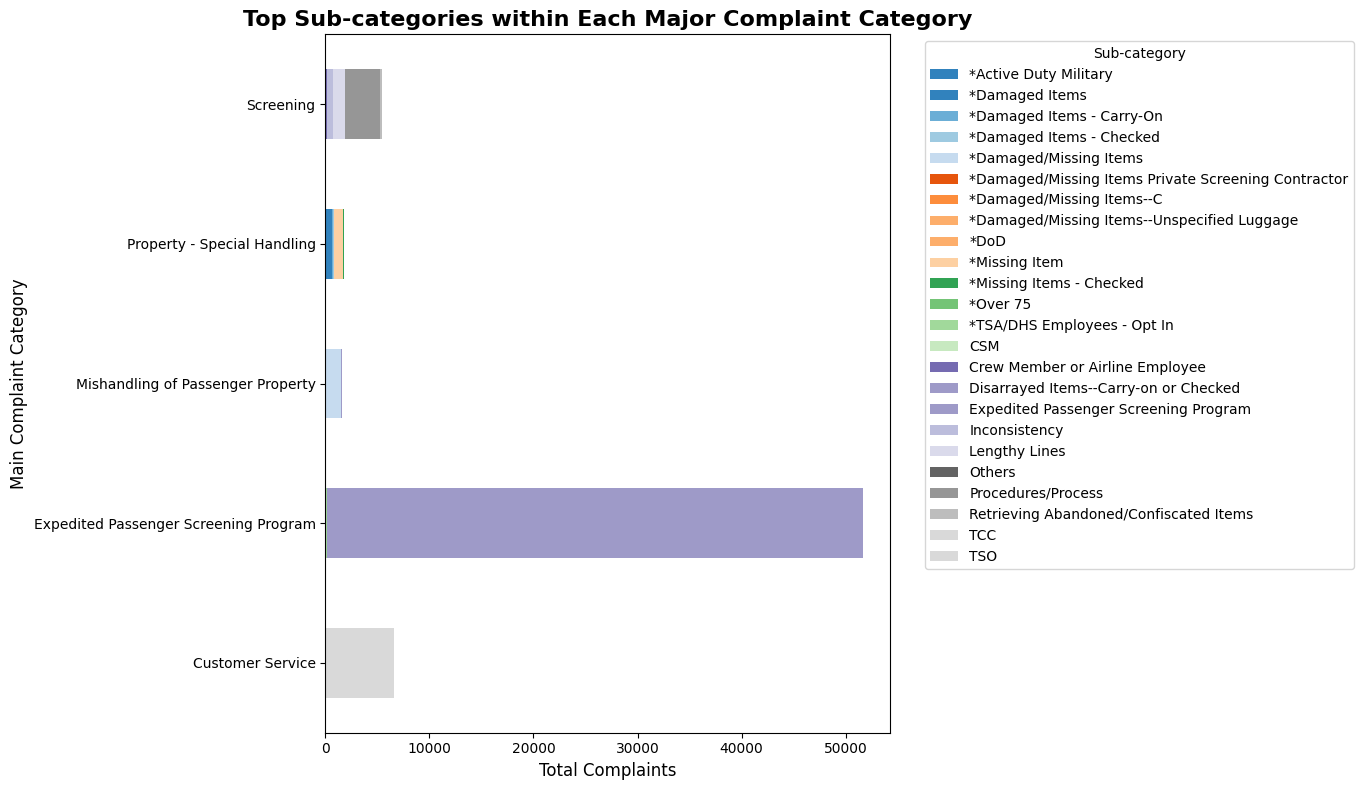

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Select the top 5 sub-categories within each main category for simplicity
filtered_data = top_subcategory_totals.groupby('category').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)

# Pivot the data for plotting
pivot_data = filtered_data.pivot(index='category', columns='sub_category', values='count').fillna(0)

# Plotting the horizontal stacked bar chart
pivot_data.plot(kind='barh', stacked=True, figsize=(14, 8), colormap='tab20c')

# Customizing the plot
plt.title('Top Sub-categories within Each Major Complaint Category', fontsize=16, fontweight='bold')
plt.xlabel('Total Complaints', fontsize=12)
plt.ylabel('Main Complaint Category', fontsize=12)
plt.legend(title='Sub-category', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot

# Display the plot
plt.tight_layout()
plt.show()





**Getting Airport data cleansed and processed**


In [29]:
import pandas as pd

# Updating iata data set and processing
# Step 1: Identifying rows with missing 'country_code' values
missing_country_code = iata_df[iata_df['country_code'].isna()]

# Step 2: Find unique region names with existing country codes for mapping
existing_country_codes = iata_df.dropna(subset=['country_code']).groupby('region_name')['country_code'].first()

# Step 3: Mapping missing 'country_code' values based on 'region_name' matches
iata_df['country_code'] = iata_df.apply(
    lambda row: existing_country_codes[row['region_name']] if pd.isna(row['country_code']) and row['region_name'] in existing_country_codes else row['country_code'],
    axis=1
)

# Step 4: Manually update 'country_code' for specific regions if still missing
iata_df.loc[(iata_df['country_code'].isna()) & 
            (iata_df['region_name'].isin(['Erongo', 'Hardap', 'Karas', 'Khomas', 'Kavango East','Khomas','Kunene','Omaheke','Oshana','Oshikoto','Otjozondjupa','Zambezi'])), 
            'country_code'] = 'NA'  # 'NA' is the ISO code for Namibia

# Step 5: Displaying rows where 'country_code' was initially missing to verify the imputation
missing_updated = iata_df[iata_df['region_name'].isin(missing_country_code['region_name'].unique())]
print("Rows where 'country_code' was initially missing and have been updated:")
print(missing_updated.head())

Rows where 'country_code' was initially missing and have been updated:
     country_code region_name iata  icao             airport  latitude  \
4834           NA      Erongo  ADI  FYAR     Arandis Airport  -22.4622   
4835           NA      Erongo  MJO  FYME  Mount Etjo Airport  -21.0233   
4836           NA      Erongo  SWP  FYSM  Swakopmund Airport  -22.6619   
4837           NA      Erongo  WVB  FYWB  Walvis Bay Airport  -22.9799   
4838           NA      Hardap  SZM  FYSS     Sesriem Airport  -24.5128   

      longitude  
4834    14.9800  
4835    16.4528  
4836    14.5681  
4837    14.6453  
4838    15.7467  


In [30]:
# Dropping records where the 'airport' column has missing values
airport_df_cleaned = airport_df.dropna(subset=['airport'])

# Checking for duplicates in 'year_month' for the same airport
duplicates = airport_df_cleaned[airport_df_cleaned.duplicated(subset=['airport', 'year_month'], keep=False)]

# Displaying the duplicate records, if any exist
if not duplicates.empty:
    print("Duplicate 'year_month' records for the same airport:")
    print(duplicates)
else:
    print("No duplicate 'year_month' records found for the same airport.")


No duplicate 'year_month' records found for the same airport.


In [31]:
# Aggregating the cleaned airport data by 'airport', 'year_month', and summing up the 'count' for complaints

# Group by 'airport' and 'year_month', summing up complaint counts
airport_aggregated = airport_df_cleaned.groupby(['airport', 'year_month'])['count'].sum().reset_index()

# Displaying the first few rows of the aggregated data
print("Aggregated airport complaints data:")
print(airport_aggregated.head())


Aggregated airport complaints data:
  airport year_month  count
0     ABE    2015-01      0
1     ABE    2015-02      0
2     ABE    2015-03      0
3     ABE    2015-04      0
4     ABE    2015-05      2


In [32]:
import pandas as pd

# Ensure 'year_month' is in datetime format
airport_aggregated['year_month'] = pd.to_datetime(airport_aggregated['year_month'], errors='coerce')

# Calculate the total complaints per airport across all available data
airport_complaint_totals = airport_aggregated.groupby('airport')['count'].sum()

# Extract the top 20 airports by total complaints
top_20_airports = airport_complaint_totals.nlargest(20).index

# Filter the dataset to only include the top 20 airports and records from 2023 and 2024
filtered_top_airports_data = airport_aggregated[
    (airport_aggregated['airport'].isin(top_20_airports)) &
    (airport_aggregated['year_month'].dt.year.isin([2022,2023, 2024]))
]



<Figure size 1400x800 with 0 Axes>

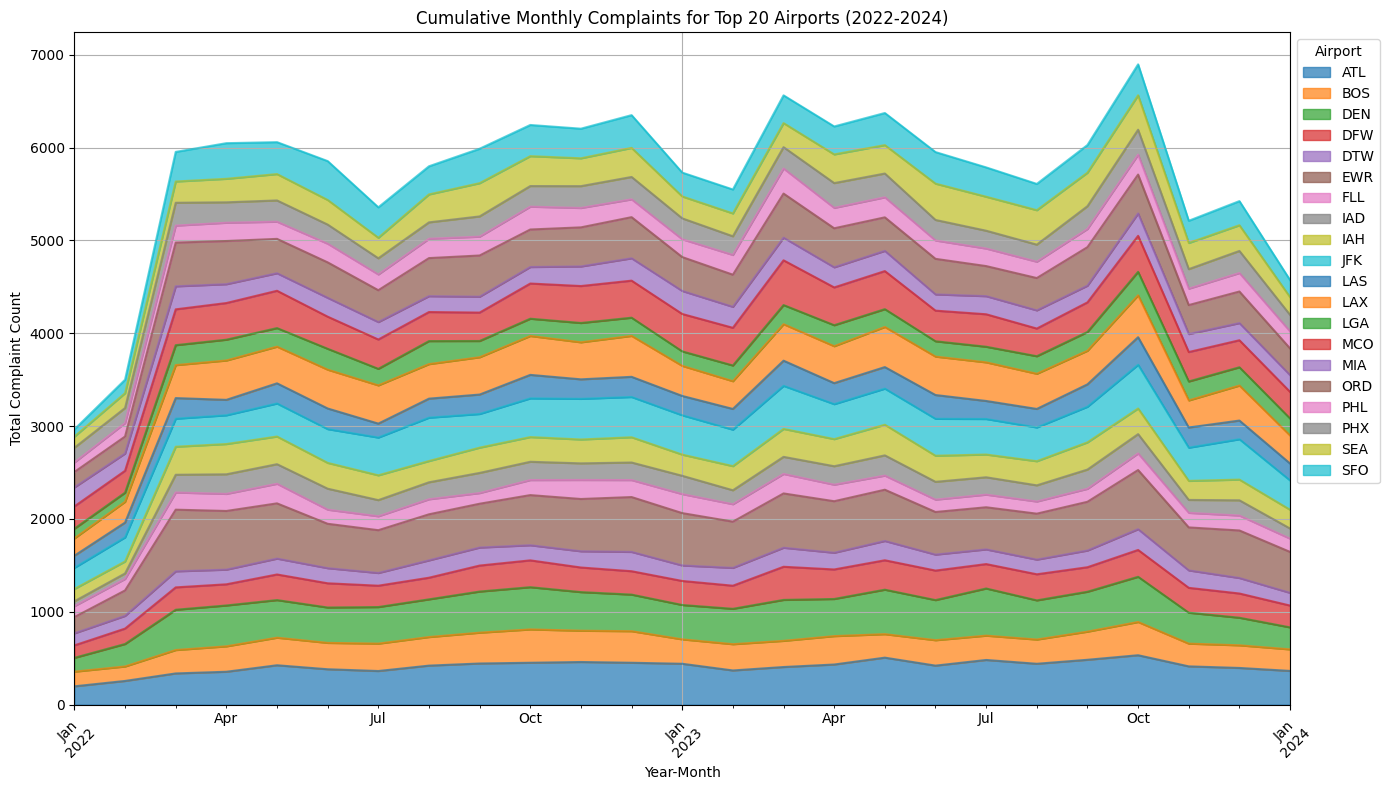

In [33]:
import matplotlib.pyplot as plt

# Pivot data to have each airport as a column with counts by month
stacked_data = filtered_top_airports_data.pivot_table(
    index='year_month', 
    columns='airport', 
    values='count', 
    aggfunc='sum'
).fillna(0)

# Plotting a stacked area chart
plt.figure(figsize=(14, 8))
stacked_data.plot(kind='area', stacked=True, figsize=(14, 8), alpha=0.7)

# Customizing the plot
plt.xlabel("Year-Month")
plt.ylabel("Total Complaint Count")
plt.title("Cumulative Monthly Complaints for Top 20 Airports (2022-2024)")
plt.xticks(rotation=45)
plt.legend(title="Airport", loc="upper left", bbox_to_anchor=(1, 1))  # Move legend outside the plot
plt.tight_layout()
plt.grid(True)

# Display the chart
plt.show()


/var/folders/h_/c1p094dx3qv9xk8qkfwl_lxm0000gn/T/ipykernel_95937/896297498.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



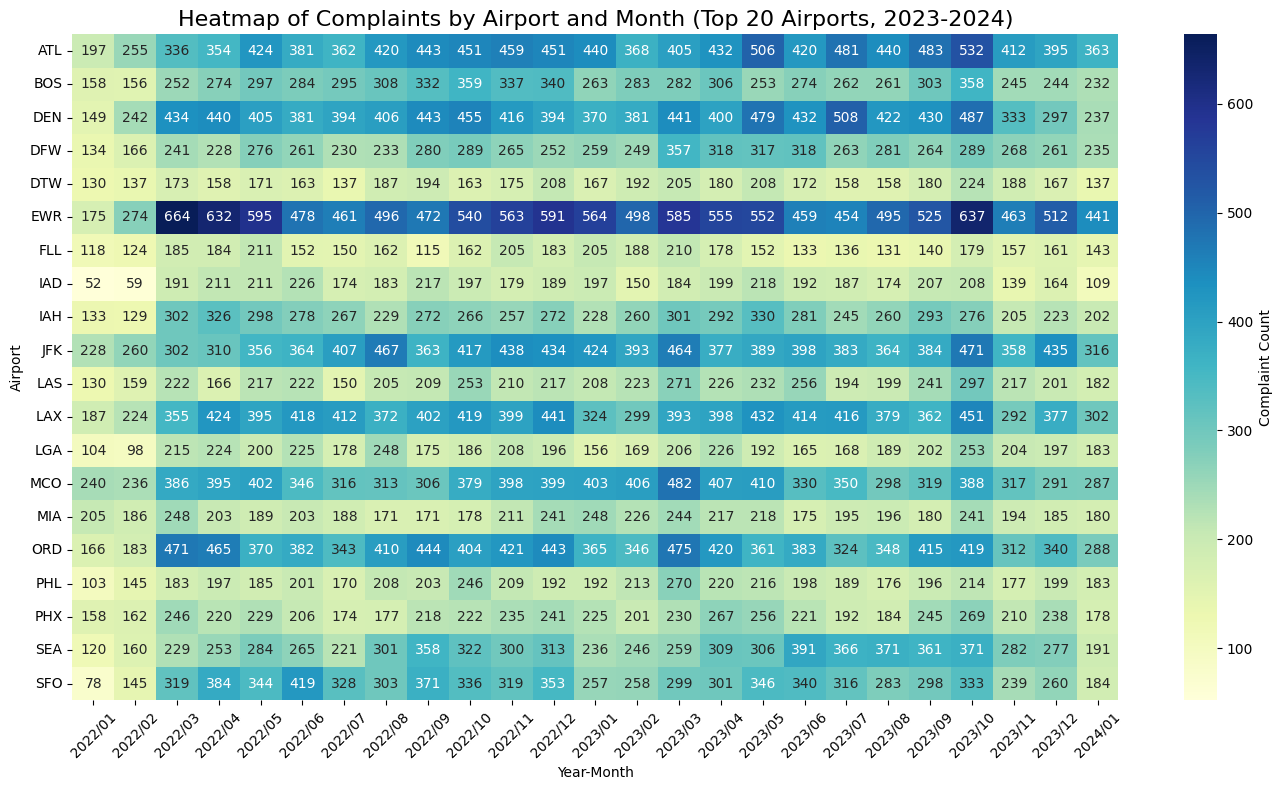

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns


# Ensure 'year_month' is in datetime format and convert to 'YYYY/MM'
filtered_top_airports_data['year_month'] = pd.to_datetime(filtered_top_airports_data['year_month'], errors='coerce').dt.strftime('%Y/%m')


# Pivot the data to create a heatmap-ready DataFrame
heatmap_data = filtered_top_airports_data.pivot_table(
    index='airport', 
    columns='year_month', 
    values='count', 
    aggfunc='sum'
).fillna(0)

# Plotting the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".0f", cbar_kws={'label': 'Complaint Count'})

# Customize the plot
plt.title("Heatmap of Complaints by Airport and Month (Top 20 Airports, 2023-2024)", fontsize=16)
plt.xlabel("Year-Month")
plt.ylabel("Airport")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [35]:
# Updating the code to handle the renaming of columns as specified

import pandas as pd


# Rename 'iata' to 'airport' and 'airport' to 'airport_name' for clarity and consistency in merging
iata_df = iata_df.rename(columns={'iata': 'airport', 'airport': 'airport_name'})

# Select only relevant columns from iata_df to streamline the merge
iata_relevant = iata_df[['country_code', 'region_name', 'airport', 'airport_name', 'latitude', 'longitude']]

# Step 3: Merge airport_aggregated with the relevant IATA data
airport_enriched = airport_aggregated.merge(
    iata_relevant,
    on='airport',
    how='left'  # Use a left join to retain all records in airport_aggregated
)

# Display the first few rows of the enriched data to verify the merge
airport_enriched.head()



,airport,year_month,count,country_code,region_name,airport_name,latitude,longitude
0,ABE,2015-01-01,0,US,Pennsylvania,Lehigh Valley International Airport,40.6521,-75.4408
1,ABE,2015-02-01,0,US,Pennsylvania,Lehigh Valley International Airport,40.6521,-75.4408
2,ABE,2015-03-01,0,US,Pennsylvania,Lehigh Valley International Airport,40.6521,-75.4408
3,ABE,2015-04-01,0,US,Pennsylvania,Lehigh Valley International Airport,40.6521,-75.4408
4,ABE,2015-05-01,2,US,Pennsylvania,Lehigh Valley International Airport,40.6521,-75.4408


In [36]:
import pandas as pd




# Convert 'year_month' to datetime if needed, then filter for the year 2023
airport_enriched['year_month'] = pd.to_datetime(airport_enriched['year_month'], errors='coerce')
airport_2023 = airport_enriched[airport_enriched['year_month'].dt.year == 2023]

# Aggregating complaint counts by airport for the year 2023
airport_2023_summary = airport_2023.groupby(['airport', 'country_code', 'region_name', 'airport_name', 'latitude', 'longitude'])['count'].sum().reset_index()

# Selecting the top 20 airports based on complaint count
top_20_airports_2023 = airport_2023_summary.nlargest(20, 'count')

# Displaying the top 20 aggregated dataset to verify
top_20_airports_2023.head()




,airport,country_code,region_name,airport_name,latitude,longitude,count
129,EWR,US,New Jersey,Newark Liberty International Airport,40.6925,-74.1686,6299
25,ATL,US,Georgia,Hartsfield-Jackson Atlanta International Airport,33.6367,-84.4281,5314
104,DEN,US,Colorado,Denver International Airport,39.8617,-104.6730,4980
205,JFK,US,New York,John F. Kennedy International Airport,40.6397,-73.7789,4840
216,LAX,US,California,Los Angeles International Airport,33.9425,-118.4080,4537


In [37]:
import pandas as pd
import plotly.graph_objects as go


# Filter for the year 2023
airport_enriched['year_month'] = pd.to_datetime(airport_enriched['year_month'], errors='coerce')
airport_enriched['month'] = airport_enriched['year_month'].dt.month  # Extract month for animation

# Filter data for 2023 and aggregate by month if animation is needed
airport_2023 = airport_enriched[airport_enriched['year_month'].dt.year == 2023]

# Aggregate complaints by airport and month for 2023
airport_2023_summary = airport_2023.groupby(['airport', 'airport_name', 'country_code', 'region_name', 'latitude', 'longitude', 'month'])['count'].sum().reset_index()

# Select top 20 airports by total complaint count for the entire year to highlight most affected airports
top_airports = airport_2023_summary.groupby('airport')['count'].sum().nlargest(20).index
top_20_airports_2023 = airport_2023_summary[airport_2023_summary['airport'].isin(top_airports)]

# Export the DataFrame to a new file with "_exported" appended
export_path = os.path.join(dataset_directory, 'top_20_airports_2023_exported.csv')

# Export the DataFrame to CSV
top_20_airports_2023.to_csv(export_path, index=False)
print(f"Exported the data to {export_path}")

Exported the data to /Users/ehabhenein/data-science-portfolio/Python_Projects/TSA Complaints/data/top_20_airports_2023_exported.csv


In [38]:
import plotly.graph_objects as go

# Dictionary for U.S. states abbreviations
state_abbreviation_map = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR", "California": "CA",
    "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE", "Florida": "FL", "Georgia": "GA",
    "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS",
    "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD", "Massachusetts": "MA",
    "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS", "Missouri": "MO", "Montana": "MT",
    "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM",
    "New York": "NY", "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK",
    "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC", "South Dakota": "SD",
    "Tennessee": "TN", "Texas": "TX", "Utah": "UT", "Vermont": "VT", "Virginia": "VA",
    "Washington": "WA", "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY"
}

# Map state names to abbreviations and aggregate state-level complaints
state_complaints = top_20_airports_2023.groupby('region_name')['count'].sum().reset_index()
state_complaints['state_abbr'] = state_complaints['region_name'].map(state_abbreviation_map)
state_complaints.dropna(subset=['state_abbr'], inplace=True)

# Aggregate top_20_airports_2023 to ensure only one entry per airport with total complaints
airport_totals = top_20_airports_2023.groupby(
    ['airport', 'airport_name', 'region_name', 'latitude', 'longitude'], as_index=False
)['count'].sum()

# Initialize the figure
fig = go.Figure()

# Add the choropleth layer for state-level complaints
fig.add_choropleth(
    locations=state_complaints['state_abbr'],
    z=state_complaints['count'],
    locationmode='USA-states',
    colorscale="Blues",
    colorbar=dict(
        title="Total Complaints by State",
        x=0.02
    ),
    marker_line_color='white',
    geo='geo'
)

# Add airport points as a scatter_geo layer with optimized marker sizes
fig.add_trace(
    go.Scattergeo(
        lon=airport_totals['longitude'],
        lat=airport_totals['latitude'],
        text=airport_totals['airport_name'] + "<br>Code: " + airport_totals['airport'] +
             "<br>Total Complaints: " + airport_totals['count'].astype(str),
        mode='markers',
        marker=dict(
            size=airport_totals['count'] / 70 + 8,  # Adjusted size for better visibility
            color=airport_totals['count'],
            colorscale=[[0, 'green'], [0.3, 'orange'], [1, 'red']],  # Custom colorscale
            opacity=0.7,
            showscale=True,
            colorbar=dict(title="Complaint Count at Airport", x=0.98)
        ),
        hoverinfo="text",
        geo='geo'
    )
)

# Generate dropdown buttons for filtering by state
buttons = [
    dict(
        args=[{
            "locations": [state],
            "z": [state_complaints[state_complaints['state_abbr'] == state]['count'].values[0]]
        }],
        label=state,
        method="update"
    ) for state in state_complaints['state_abbr']
]

# Add "Show All" button to reset the map to display all states
buttons.insert(0, dict(
    args=[{"locations": state_complaints['state_abbr'].tolist(), "z": state_complaints['count'].tolist()}],
    label="Show All",
    method="update"
))

# Customize layout with dropdown filter and geo settings
fig.update_layout(
    title=dict(
        text="Top 20 U.S. Airports by Complaint Count in 2023 with State Highlights",
        x=0.5,
        xanchor='center'
    ),
    geo=dict(
        scope='usa',
        showland=True,
        landcolor="lightgray",
        showcountries=False,
        subunitcolor="white"
    ),
    width=1200,
    height=800,
    updatemenus=[{
        "buttons": buttons,
        "direction": "up",
        "showactive": True,
        "x": .01,
        "xanchor": "center",
        "y": 0.9,
        "yanchor": "top"
    }]
)

# Show the plot
fig.show()
